In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('/Users/wyattscott/Documents/DS5110/Project')

import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pickle

import warnings
warnings.filterwarnings('ignore')


from scipy.stats import randint
from pandas_profiling import ProfileReport

# <a href="https://thejk.medium.com/i-will-predict-the-2023-nba-mvp-using-machine-learning-8e7ed688b0d3">Data Source</a>:

### <a href="https://www.kaggle.com/datasets/danchyy/nba-mvp-votings-through-history?resource=download">Alternative Data Source (cleaner but not as up to date)</a>:

## <a href="https://www.basketball-reference.com/about/glossary.html">Variable Definitions</a>:

In [50]:
df = pd.read_csv('mvp_data.csv')
#df.head(2)

In [51]:
#print(df.columns)

# Cleaning:

One possible issue here is that the rules change over time, for example, the minimum number of games a player must be on the court for recently changed to 65. In the code below, it's set at 40...

In [52]:
# Fill missing values
df['Rank'].fillna(0, inplace=True)
df['mvp_share'].fillna(0.0, inplace=True)
df['Trp Dbl'].fillna(0, inplace=True)

# Normalize Triple Double
df['Trp Dbl'] = df['Trp Dbl'] / df['G']

# Convert 'G' and 'Season' to integer type
df['G'] = df['G'].astype(int)
df['Season'] = df['Season'].astype(int)

# Filter out data based on conditions
###df = df[(df['G'] > 40) & (df['Season'] <= 2022)]
# See what happens if we make it 65
df = df[(df['G'] > 65) & (df['Season'] <= 2022)]


# Ranking Conference
df['Rk_Conference'] = df.groupby(['Season', 'conference'])['W'].rank("dense", ascending=False) + df['Rk_Season']
df['Rk_Conference'] = df.groupby(['Season', 'conference'])['Rk_Conference'].rank("dense", ascending=True)

# Save cleaned data to CSV
df.drop(columns=['conference', 'W'], inplace=True)
#df.to_csv("mvp_data_edit.csv", index=False, encoding="utf-8-sig")

# Sort out seasons for which a prediction is made
df.sort_values(by=['Season'], ascending=False, inplace=True)
df_last = df[df['Season'] > (2022 - 5)] 
last_names = df_last['name'].values
last_seasons = df_last['Season'].values
del df_last['name']
del df_last['Season']
del df_last['Rank']
del df_last['mvp_share']

# Filter out seasons older than 5 years
df = df[df['Season'] <= (2022 - 5)].copy()
df.drop(columns=['name'], inplace=True)

In [53]:
last_names = pd.DataFrame(last_names, columns=['name'])
last_seasons = pd.DataFrame(last_seasons, columns=['Season'])
last_names.to_csv('last_names.csv', index=False)
last_seasons.to_csv('last_seasons.csv', index=False)

In [29]:
#df.columns

In [30]:
#df.isnull().sum()

### There are a lot of NaN values, so we'll need to clean further and investigate. 3-point shots weren't introduced until 1979-80 and there are a lot of NaN values before then, so dropping any season < 1980

In [31]:
df = df[df['Season'] >= 1980]
df.drop(['Season'], axis="columns", inplace=True)
#df.to_csv('df_clean.csv', index=False)
#df_last.to_csv('df_last.csv', index=False)

In [ ]:
label_col_name = "mvp_share"
labels = df.pop(label_col_name)
stratify = df.pop("Rank")

In [21]:
#df.columns

Index(['height', 'weight', 'Age', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'Trp Dbl', 'Rk_Season', 'Overall', 'Rk_Conference'],
      dtype='object')

In [9]:
#df.isnull().sum()

## There are still some null values: 
* 1085 3P% (3-point percent)
* 430 for GS (games started)
* 2 for FT% (free throw percent)

<h2 style='color:Red'>I'll create a separate df and fill these NaNs with 0 for now, but we must revisit</h2>

In [10]:
df_corr = df.copy()
df_corr.fillna(0, inplace=True)
# Drop position column for corrplot below
df_corr.drop(['Pos'], axis="columns", inplace=True)

# EDA 

### `Pandas_Profiling`

I commented this out but feel free to run it (if you want it to be faster set `minimal=True`)

In [11]:
profile = ProfileReport(df, 
                        title='Pandas Profiling Report',
                        html={'style':{'full_width':True}},
                       minimal=True)
profile.to_notebook_iframe()

### sns `Corrplot`

In [12]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Preprocessing etc.

### Dropping `FTA`, `FT` and `FG`, `PTS`, dropping `2P` since it's highly correlated with `BPM` to see what we get given these sets are highly correlated.

In [13]:
df = df.drop(columns=['FT', 'FTA', 'FG', 'PTS', '2P', 
                      'FGA', '2PA', 'WS/48', 'OBPM', 
                      'USG%', 'TRB', 'MP'])

df_last = df_last.drop(columns=['FT', 'FTA', 'FG', 'PTS', '2P', 
                                'FGA', '2PA', 'WS/48', 'OBPM', 
                                'USG%', 'TRB', 'MP'])

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=28)

In [15]:
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Last {5} Season Shape: {df_last.shape}")

X_train Shape: (5863, 41)
y_train Shape: (5863,)
X_test Shape: (1466, 41)
y_test shape: (1466,)
Last 5 Season Shape: (730, 41)


### A bit of preprocessing
Handling missing values, scaling numerical features, and performing one-hot encoding on categorical features.

In [16]:
# Convert NumPy arrays back to pandas DataFrames
X_train = pd.DataFrame(X_train, columns=df.columns)
X_test = pd.DataFrame(X_test, columns=df.columns)
df_last = pd.DataFrame(df_last, columns=df_last.columns)

# Define numeric columns excluding "Pos"
numeric_col = [col for col in df.columns if col != "Pos"]

# Numeric Pipeline
numeric_pipe = Pipeline(steps=[
    ('imp_median', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())])

# Column Transformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(sparse=False), ['Pos']),
    ('num', numeric_pipe, numeric_col)
])

# Fit the column transformer on training data and transform both training and testing data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Transform df_last using the fitted preprocessor
df_last_transformed = preprocessor.transform(df_last)

header_names = [col.split("__")[1] for col in preprocessor.get_feature_names_out()]

# Define the regressor
regressor = SVR(kernel="linear")

# Combine preprocessing and regressor into one pipeline
## SelectKBest with f_regression scoring
pipeline = Pipeline(steps=[
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),  
    ('regressor', regressor)
])

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

# Evaluate on test data
accuracy = pipeline.score(X_test, y_test)

# Get selected feature indices
selected_indices = pipeline.named_steps['feature_selection'].get_support(indices=True)

# Extract feature names
selected_feature_names = [header_names[i] for i in selected_indices]

print("Selected Features:", selected_feature_names)

Selected Features: ['DRB', 'AST', 'TOV', 'PER', 'OWS', 'DWS', 'WS', 'BPM', 'VORP', 'Trp Dbl']


## Check correlation of selected features:

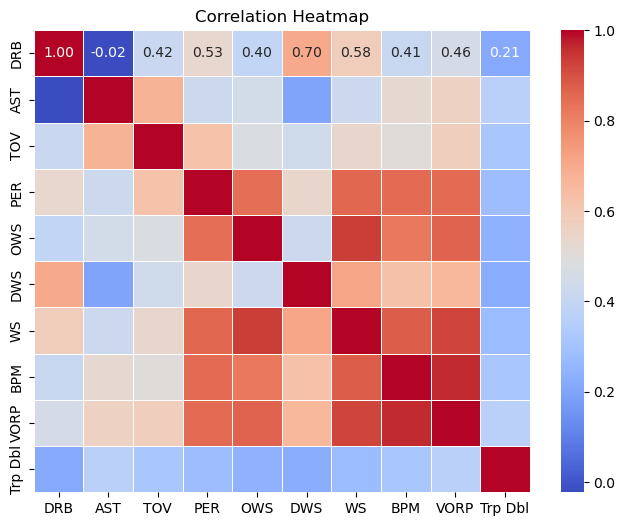

In [17]:
df_check_selected = df[['DRB', 'AST', 'TOV', 'PER', 'OWS', 'DWS', 'WS', 'BPM', 'VORP', 'Trp Dbl']]
corr_matrix = df_check_selected.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [18]:
# Filter the training and testing data to include only selected features
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

df_last_transformed = pd.DataFrame(df_last_transformed, columns=header_names)
# Use only selected features for df_last
df_last = df_last_transformed[selected_feature_names]

---

# Modeling

### Basic linear regression

In [19]:
# Initialize a linear regression model
linear_model = LinearRegression()

# Fit the model on the preprocessed training data
linear_model.fit(X_train_selected, y_train)

# Make predictions on the test data using the model fitted on selected features
test_predictions_selected = linear_model.predict(X_test_selected)

# Evaluate the model using mean squared error and R-squared on selected features
test_mse_selected = mean_squared_error(y_test, test_predictions_selected)
test_r2_selected = r2_score(y_test, test_predictions_selected)

print("Test MSE (Linear Regression - Selected Features):", test_mse_selected)
print("Test R-squared (Linear Regression - Selected Features):", test_r2_selected)

Test MSE (Linear Regression - Selected Features): 0.00439420703560646
Test R-squared (Linear Regression - Selected Features): 0.3655510246422836


### RandomForestRegressor

In [21]:
# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=28)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf,
                                      n_iter=50, scoring='r2', cv=10, random_state=28)

# Perform random search
random_search_rf.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_params_rf = random_search_rf.best_params_
print("Best Hyperparameters (Random Forest):", best_params_rf)

# Get the best model
best_rf_model = random_search_rf.best_estimator_

# Make predictions on the test data using the best model
test_predictions_best_rf = best_rf_model.predict(X_test_selected)

# Evaluate the best model using mean squared error and R-squared
test_mse_best_rf = mean_squared_error(y_test, test_predictions_best_rf)
test_r2_best_rf = r2_score(y_test, test_predictions_best_rf)

print("Test MSE (Best Random Forest):", test_mse_best_rf)
print("Test R-squared (Best Random Forest):", test_r2_best_rf)

Best Hyperparameters (Random Forest): {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Test MSE (Best Random Forest): 0.0020725588790515494
Test R-squared (Best Random Forest): 0.7007576460262723


### GradientBoostingRegressor

In [247]:
# Define the hyperparameter grid
param_grid_gb = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.15],  # Learning rate
    'max_depth': [3, 5, 7],  # Maximum depth of the individual trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for fitting the individual base learners
    'max_features': ['auto', 'sqrt']  # Number of features to consider when looking for the best split
}

# Initialize GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=28)

# Initialize RandomizedSearchCV
random_search_gb = RandomizedSearchCV(estimator=gb_model, param_distributions=param_grid_gb,
                                      n_iter=50, scoring='r2', cv=10, random_state=28)

# Perform random search
random_search_gb.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_params_gb = random_search_gb.best_params_
print("Best Hyperparameters (Gradient Boosting):", best_params_gb)

# Get the best model
best_gb_model = random_search_gb.best_estimator_

# Make predictions on the test data using the best model
test_predictions_best_gb = best_gb_model.predict(X_test_selected)

# Evaluate the best model using mean squared error and R-squared
test_mse_best_gb = mean_squared_error(y_test, test_predictions_best_gb)
test_r2_best_gb = r2_score(y_test, test_predictions_best_gb)

print("Test MSE:", test_mse_best_gb)
print("Test R-squared:", test_r2_best_gb)

Best Hyperparameters (Gradient Boosting): {'subsample': 0.6, 'n_estimators': 100, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.05}
Test MSE (Best Gradient Boosting): 0.0020839740758370274
Test R-squared (Best Gradient Boosting): 0.6991094851987629


### XGBRegressor

In [240]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'learning_rate': [0.05, 0.1, 0.15],  # Learning rate
    'max_depth': [3, 5, 7],  # Maximum depth of each tree
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instance
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
    'reg_lambda': [0, 0.1, 0.5]  # L2 regularization term on weights
}

# Initialize XGBRegressor
xgb_model = XGBRegressor(random_state=28)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                   n_iter=50, scoring='r2', cv=5, random_state=28)

# Perform random search
random_search.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_xgb_model = random_search.best_estimator_

# Make predictions on the test data using the best model
test_predictions_best_xgb = best_xgb_model.predict(X_test_selected)

# Evaluate the best model using mean squared error and R-squared
test_mse_best_xgb = mean_squared_error(y_test, test_predictions_best_xgb)
test_r2_best_xgb = r2_score(y_test, test_predictions_best_xgb)

print("Test MSE (Best XGBoost):", test_mse_best_xgb)
print("Test R-squared (Best XGBoost):", test_r2_best_xgb)

Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Test MSE (Best XGBoost): 0.0022419207935488327
Test R-squared (Best XGBoost): 0.6763046577517695


### NeuralNet

In [241]:
# Define the hyperparameter grid
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Number of neurons in each hidden layer
    'activation': ['relu'],  # Activation function for the hidden layers
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rate
    'max_iter': [300, 400, 500],  # Maximum number of iterations
}

# Initialize MLPRegressor
mlp_model = MLPRegressor(random_state=28)

# Initialize RandomizedSearchCV
random_search_mlp = RandomizedSearchCV(estimator=mlp_model, param_distributions=param_grid_mlp,
                                       n_iter=50, scoring='r2', cv=10, random_state=28)

# Perform random search
random_search_mlp.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_params_mlp = random_search_mlp.best_params_
print("Best Hyperparameters (MLP):", best_params_mlp)

# Get the best model
best_mlp_model = random_search_mlp.best_estimator_

# Make predictions on the test data using the best model
test_predictions_best_mlp = best_mlp_model.predict(X_test_selected)

# Evaluate the best model using mean squared error and R-squared
test_mse_best_mlp = mean_squared_error(y_test, test_predictions_best_mlp)
test_r2_best_mlp = r2_score(y_test, test_predictions_best_mlp)

print("Test MSE (Best MLP):", test_mse_best_mlp)
print("Test R-squared (Best MLP):", test_r2_best_mlp)

Best Hyperparameters (MLP): {'max_iter': 400, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 50), 'alpha': 0.01, 'activation': 'relu'}
Test MSE (Best MLP): 0.0024597493553108877
Test R-squared (Best MLP): 0.6448539075495758


## Neural Net 2

In [242]:
print(f'Train predictors shape: {X_train_selected.shape}')
print(f'Train response shape: {y_train.shape}')
print(f'Test predictors shape: {X_test_selected.shape}')
print(f'Test response shape: {y_test.shape}')

Train predictors shape: (5863, 10)
Train response shape: (5863,)
Test predictors shape: (1466, 10)
Test response shape: (1466,)


### Comparing model results:

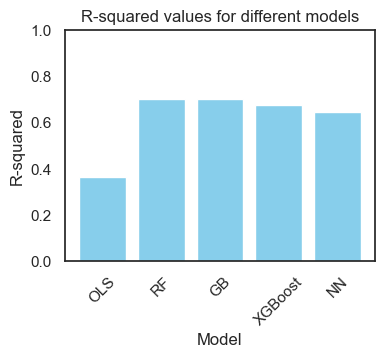

In [244]:
r_sqs = [test_r2_selected, test_r2_best_rf, test_r2_best_gb, test_r2_best_xgb, test_r2_best_mlp]

# List of model names
model_names = ['OLS', 'RF', 'GB', 'XGBoost', 'NN']

# Plot the bar chart
plt.figure(figsize=(4, 3))
plt.bar(model_names, r_sqs, color='skyblue')
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.title('R-squared values for different models')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Set the y-axis limit to be between 0 and 1
plt.show()

# Predict past 5 seasons

In [245]:
# Concatenate df_last, last_seasons, and last_names
concatenated_data = np.concatenate([df_last.to_numpy(), last_seasons.reshape(-1, 1), last_names.reshape(-1, 1)], axis=1)

# Create DataFrame with appropriate column names
df_n_last = pd.DataFrame(data=concatenated_data, 
                         columns=selected_feature_names + ['Season', 'Name'])

dfs_n_last = []
for season_n in df_n_last['Season'].unique():
    df_n = df_n_last[df_n_last['Season'] == season_n].copy()
    names_n = df_n["Name"].values
    df_n.drop(['Season', 'Name'], axis="columns", inplace=True)
    feature_n = df_n.to_numpy()

    # Get the indices of the selected feature names
    selected_indices = [df_last.columns.get_loc(col) for col in selected_feature_names]
    
    # Select only the selected features for prediction
    feature_n_selected = feature_n[:, selected_indices]
    
    # Predict MVP shares for the current season
    prediction = best_rf_model.predict(feature_n_selected)

    # Create DataFrame for the current season's predictions using selected features
    df_curr_season_victory = pd.DataFrame(data=feature_n_selected, columns=selected_feature_names)
    df_curr_season_victory['Season'] = season_n
    df_curr_season_victory['Player'] = names_n
    df_curr_season_victory['MVP_Shares_in_%'] = prediction * 100
    
    # Sort DataFrame by MVP shares
    df_curr_season_victory = df_curr_season_victory.sort_values(by=['MVP_Shares_in_%'], ascending=False)
    
    # Print and append DataFrame
    print(season_n)
    print(df_curr_season_victory[['Player', 'MVP_Shares_in_%']].head(8))
    print("=============================================================================")
    print("============================================================================\n")
    
    dfs_n_last.append(df_curr_season_victory)

# Concatenate DataFrames for all seasons
dfs_n_last = pd.concat(dfs_n_last, ignore_index=True)

2022
                    Player  MVP_Shares_in_%
57            Nikola Jokić        62.269030
18   Giannis Antetokounmpo        36.995245
78             Joel Embiid        33.058220
117             Trae Young        14.224414
131        Dejounte Murray         7.857555
24             Rudy Gobert         7.762436
49      Karl-Anthony Towns         7.323246
139           Jayson Tatum         4.161809

2021
              Player  MVP_Shares_in_%
13      Nikola Jokić        60.914698
76       Luka Dončić        22.721842
73    Damian Lillard         9.387057
39       Rudy Gobert         6.125924
33    Nikola Vučević         4.397551
57     Julius Randle         1.213657
35      Enes Freedom         0.753451
26  Montrezl Harrell         0.417444

2020
               Player  MVP_Shares_in_%
22       LeBron James        28.705485
44       James Harden        27.905544
80     Damian Lillard        20.441917
69       Nikola Jokić        15.467473
34   Hassan Whiteside         1.976280
15        R

# Shap

  0%|          | 0/2257 [00:00<?, ?it/s]

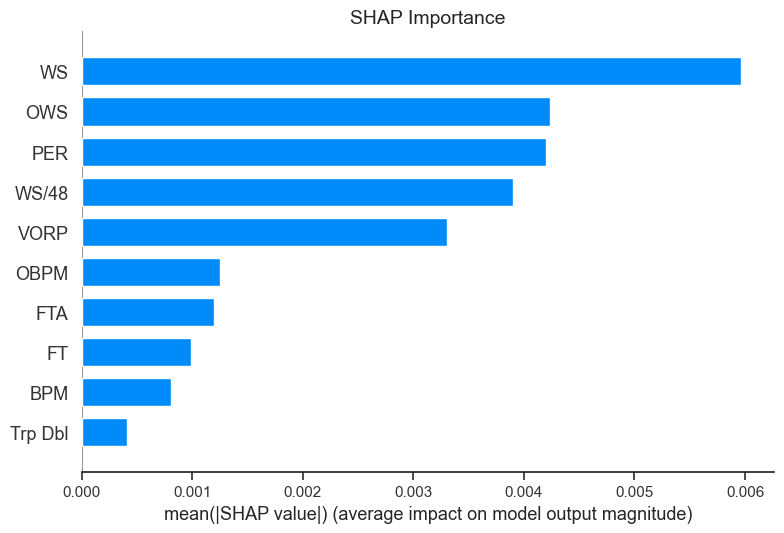

In [166]:
background_summary = shap.sample(X_train_selected, 50)

# Create a KernelExplainer for your MLP model with the summarized background data
explainer = shap.KernelExplainer(best_mlp_model.predict, background_summary)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_selected)

# Plot
shap.summary_plot(shap_values, X_test_selected, plot_type="bar", feature_names=selected_feature_names, 
                  show=False, max_display=15)
plt.title("SHAP Importance", fontsize=14, loc="center")   
plt.tight_layout()
plt.show()